In [69]:
import torch

In [2]:
# train mobile and simple cnn 

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"training on {device}")

training on cuda


In [75]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

class MobileNet(nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()
        net = models.mobilenet_v3_small(pretrained=False)
        
        self.trunk = nn.Sequential(*(list(net.children())[:-2]))
        
        
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Sequential(
            nn.Linear(576, 10, bias=True),
            nn.LogSoftmax(dim=1)
        )
        

    def forward(self, x):
        
        x = self.trunk(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            model = model.to(device)
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
    # Training settings

    no_cuda = False
    seed = 1111
    batch_size = 128
    test_batch_size = 1000
    lr = 0.01
    save_model = True
    epochs = 4
    
    use_cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': batch_size,'shuffle':True}
    test_kwargs = {'batch_size': test_batch_size,'shuffle':True}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': False}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.ImageFolder('mnist/training',transform=transform)
    dataset2 = datasets.ImageFolder('mnist/testing',transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs,)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    #model = MobileNet().to(device)
        
    optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=lr)

    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
    for epoch in range(1, epochs + 1):
        train( model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")
        #torch.save(model.state_dict(), "mnist_mobile.pt")
    
    
    return model



In [76]:
model = main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.213348
Train Epoch: 1 [12800/60000 (21%)]	Loss: 4.161409
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.100485
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.855450
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.402011

Test set: Average loss: 4.3814, Accuracy: 1009/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 5.734994
Train Epoch: 2 [12800/60000 (21%)]	Loss: 4.088257
Train Epoch: 2 [25600/60000 (43%)]	Loss: 3.808168
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.673404
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.358253

Test set: Average loss: 2.9362, Accuracy: 1009/10000 (10%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 3.905466
Train Epoch: 3 [12800/60000 (21%)]	Loss: 4.129701
Train Epoch: 3 [25600/60000 (43%)]	Loss: 3.838623
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.707532
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.308304

Test set: Average loss: 2.9517, Accuracy: 1009/10000 (10%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 3.925500
Train Epoch: 4 [12800/60000 (21%)]	Lo

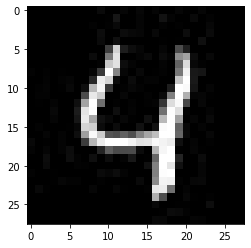

In [77]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

four_img = Image.open("mnist/pic/4.jpg")
four_img = four_img.convert('RGB')
transform=transforms.Compose([
        transforms.ToTensor()  
        ])

norm=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])


four_tensor = transform(four_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(four_tensor[0].numpy().transpose(1,2,0))


In [78]:
four_tensor = four_tensor.to(device)


In [79]:

def cnn_eval(tensor):
    model=Net().to(device)
    model.load_state_dict(torch.load("mnist_cnn.pt"))
    model.eval()
    print(torch.argmax(model(tensor)))

def mobile_eval(tensor):
    model=MobileNet().to(device)
    model.load_state_dict(torch.load("mnist_mobile.pt"))
    model.eval()
    print(torch.argmax(model(tensor)))

mobile_eval(norm(four_tensor))
cnn_eval(norm(four_tensor))

tensor(4, device='cuda:0')
tensor(9, device='cuda:0')


In [30]:
## fgsm to get a wrong prediction

In [34]:
pred

tensor([[-3.9055, -3.7858, -3.6674, -3.5200, -3.3522, -3.1603, -2.8948, -2.5164,
         -1.8306, -0.6382]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-3.3522, device='cuda:0', grad_fn=<NegBackward>)
tensor(9, device='cuda:0')
None


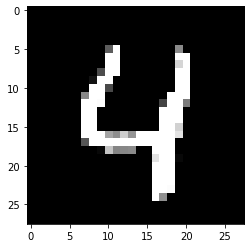

In [37]:
gt = 4
delta = torch.zeros_like(four_tensor, requires_grad=True).to(device)
opt = optim.SGD([delta], lr=10)
epsilon = 0.2
for t in range(20):
    pred = model(norm(four_tensor + delta))

    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([gt]).to(device))
    

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
print(loss)
print(cnn_eval(norm(four_tensor + delta)))
plt.imshow(norm(four_tensor + delta)[0].detach().cpu().numpy().transpose(1,2,0))


In [38]:
# pgd more powerful 
# targeted attack: control model to give a target value

In [42]:
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

8
0 10.363876342773438
50 -12.074045181274414
100 -13.779844284057617
150 -14.100808143615723
200 -14.469240188598633
250 -14.536497116088867
300 -14.619895935058594
350 -14.487329483032227
400 -14.758809089660645
450 -14.880974769592285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True class probability: tensor([[1.6331e-09, 1.1440e-09, 7.0457e-08, 5.8466e-05, 2.4390e-13, 9.1452e-09,
         1.8638e-10, 2.0460e-10, 9.9994e-01, 3.9326e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')


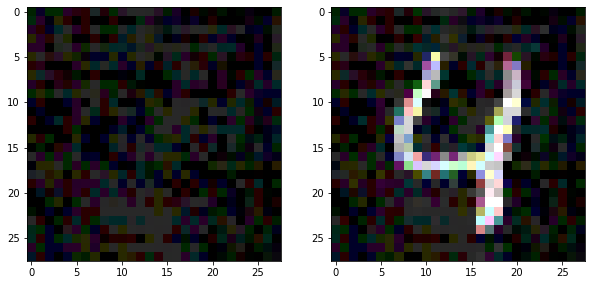

In [67]:
import torch.optim as optim

model.eval()
def l_infinity_pgd(model, tensor, gt,epsilon=40./255, target=None,iteration=500, show=True):
    tensor = tensor.to(device)
    delta = torch.zeros_like(tensor).to(device)
    model = model.to(device)
    delta.requires_grad=True
    opt = optim.SGD([delta], lr=0.1)
    print(target)
    for t in range(iteration):
        pred = model(norm(tensor + delta))
        if target is None:
            loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([gt]).to(device))
        else:

            loss = - 0.5 * nn.CrossEntropyLoss()(pred, torch.LongTensor([4]).to(device)) + nn.CrossEntropyLoss()(pred, torch.LongTensor([target]).to(device))
        if t % 50 == 0:
            print(t, loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()
        delta.data.clamp_(-epsilon, epsilon)

    print("True class probability:", nn.Softmax(dim=1)(pred))
    cnn_eval(norm(tensor+delta))

    if show:
        f,ax = plt.subplots(1,2, figsize=(10,5))
        ax[0].imshow((delta)[0].detach().cpu().numpy().transpose(1,2,0))
        ax[1].imshow((tensor + delta)[0].detach().cpu().numpy().transpose(1,2,0))
    
    return tensor + delta

x= l_infinity_pgd(model,four_tensor,4,target=8)

In [ ]:
## 是不是像才可以？铁男都可以是数字？？？ 其实图片越复杂，对抗扰动就越难以察觉

tensor(9, device='cuda:0')


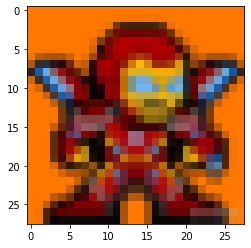

In [46]:
import torch.optim as optim

rem_img = Image.open("mnist/pic/tienan.jpeg")
rem_img = rem_img.convert('RGB')
transform=transforms.Compose([
    transforms.Resize((28,28))  ,
        transforms.ToTensor()  
        ])

norm=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])


rem_tensor = transform(rem_img)[None,:,:,:]
cnn_eval(norm(rem_tensor.to(device)))
plt.imshow(rem_tensor[0].cpu().numpy().transpose(1,2,0))


In [50]:
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

6
0 1.2186567783355713
50 1.2186567783355713
100 1.2186567783355713
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')


tensor([[[[0.9961, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 0.9882, 0.7725,  ..., 0.7843, 0.9882, 1.0000],
          [1.0000, 0.9608, 0.2941,  ..., 0.4196, 0.9020, 0.9686],
          [0.9961, 0.9608, 0.2784,  ..., 0.3412, 0.9294, 0.9765]],

         [[0.4706, 0.4667, 0.4667,  ..., 0.4667, 0.4667, 0.4745],
          [0.4667, 0.4667, 0.4667,  ..., 0.4667, 0.4667, 0.4745],
          [0.4667, 0.4667, 0.4667,  ..., 0.4667, 0.4667, 0.4745],
          ...,
          [0.4667, 0.4627, 0.3725,  ..., 0.3765, 0.4627, 0.4745],
          [0.4667, 0.4510, 0.1451,  ..., 0.3098, 0.5412, 0.4980],
          [0.4745, 0.4588, 0.1451,  ..., 0.2157, 0.4980, 0.4902]],

         [[0.0078, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0157],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0157],
          [0.0039, 0.0039, 0.0039,  ..., 0

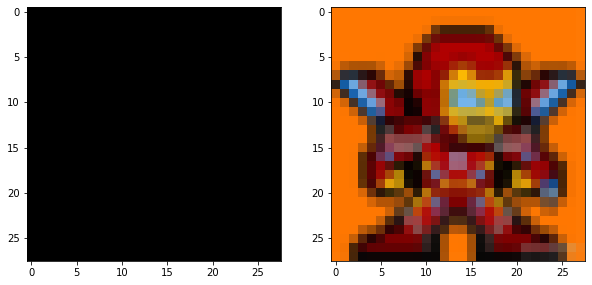

In [54]:

import torch.optim as optim
# 注意修改gt为输出值
pred = 9
l_infinity_pgd(model,rem_tensor,pred,20./255,6,150)

In [55]:
# 统一视角 各种算法 
# 1) the norm ball perturbation they consider, 
# 2) the method they use for optimizing over that norm ball

In [56]:
# transfer attack 使用simple cnn产生的攻击样本，对mobile会有影响吗？


In [68]:
# create dataset
import os
from torchvision.utils import save_image
def create_adv_dataset():
    transform=transforms.Compose([
        transforms.ToTensor()
        ])
    dataset1 = datasets.ImageFolder('mnist/training',transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,batch_size=1, shuffle=True, num_workers=8)
    
    attack_target = 0 
    # 每个数字生成100个对抗样本
    for batch_idx, (data, target) in enumerate(train_loader):
        attack_target = batch_idx//100
        if target== attack_target:
            continue
        if attack_target>9:
            break
        model=Net()
        model.load_state_dict(torch.load("mnist_cnn.pt"))
        model.eval()
        adv_img = l_infinity_pgd(model,data,target,35./255,attack_target,50,False)
        image_dir_1 = os.path.join('mnist/adv_ori_label',str(target.item()))
        image_dir_2 = os.path.join('mnist/adv_adv_label',str(attack_target))
        if not os.path.exists(image_dir_1):
            os.makedirs(image_dir_1)
        if not os.path.exists(image_dir_2):
            os.makedirs(image_dir_2)
        
        save_image(adv_img, os.path.join(image_dir_1,str(batch_idx)+'.jpg'))
        save_image(adv_img, os.path.join(image_dir_2,str(batch_idx)+'.jpg'))

create_adv_dataset()    

0
0 2.229358673095703
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
0
0 2.229358673095703
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
0
0 2.229358673095703
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
0
0 2.229358673095703
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
0
0 2.229358673095703
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
     

tensor(9, device='cuda:0')
0
0 2.229358673095703
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
0
0 2.229358673095703
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
0
0 2.229358673095703
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
0
0 2.229358673095703
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
0
0 2.229358673095703
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.

True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
0
0 2.229358673095703
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
0
0 2.229358673095703
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
0
0 2.229358673095703
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
0
0 2.229358673095703
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='

True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
1
0 2.109665870666504
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
1
0 2.109665870666504
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
1
0 2.109665870666504
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
1
0 2.109665870666504
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='

True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
1
0 2.109665870666504
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
1
0 2.109665870666504
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
1
0 2.109665870666504
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
1
0 2.109665870666504
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='

True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
2
0 1.9913341999053955
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
2
0 1.9913341999053955
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
2
0 1.9913341999053955
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
2
0 1.9913341999053955
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], devi

True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
2
0 1.9913341999053955
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
2
0 1.9913341999053955
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
2
0 1.9913341999053955
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
2
0 1.9913341999053955
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], devi

True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
2
0 1.9913341999053955
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
2
0 1.9913341999053955
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
2
0 1.9913341999053955
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
3
0 1.8438787460327148
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], devi

True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
3
0 1.8438787460327148
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
3
0 1.8438787460327148
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
3
0 1.8438787460327148
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
3
0 1.8438787460327148
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], devi

True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
3
0 1.8438787460327148
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
3
0 1.8438787460327148
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
3
0 1.8438787460327148
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
3
0 1.8438787460327148
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], devi

True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
4
0 1.6761090755462646
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
4
0 1.6761090755462646
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
4
0 1.6761090755462646
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
4
0 1.6761090755462646
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], devi

True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
4
0 1.6761090755462646
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
4
0 1.6761090755462646
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
4
0 1.6761090755462646
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
4
0 1.6761090755462646
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], devi

True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
5
0 1.4841735363006592
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
5
0 1.4841735363006592
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
5
0 1.4841735363006592
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
5
0 1.4841735363006592
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], devi

True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
5
0 1.4841735363006592
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
5
0 1.4841735363006592
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
5
0 1.4841735363006592
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
5
0 1.4841735363006592
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], devi

True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
5
0 1.4841735363006592
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
5
0 1.4841735363006592
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
5
0 1.4841735363006592
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
5
0 1.4841735363006592
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], devi

True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
6
0 1.2186567783355713
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
6
0 1.2186567783355713
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
6
0 1.2186567783355713
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
6
0 1.2186567783355713
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], devi

True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
6
0 1.2186567783355713
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
6
0 1.2186567783355713
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
6
0 1.2186567783355713
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
6
0 1.2186567783355713
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], devi

tensor(9, device='cuda:0')
7
0 0.8403208255767822
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
7
0 0.8403208255767822
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
7
0 0.8403208255767822
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
7
0 0.8403208255767822
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
7
0 0.8403208255767822
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.042

True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
7
0 0.8403208255767822
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
7
0 0.8403208255767822
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
7
0 0.8403208255767822
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
7
0 0.8403208255767822
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], devi

True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
8
0 0.15446233749389648
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
8
0 0.15446233749389648
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
8
0 0.15446233749389648
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
8
0 0.15446233749389648
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], 

True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
8
0 0.15446233749389648
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
8
0 0.15446233749389648
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
8
0 0.15446233749389648
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
8
0 0.15446233749389648
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], 

True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
8
0 0.15446233749389648
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
8
0 0.15446233749389648
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
8
0 0.15446233749389648
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
8
0 0.15446233749389648
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], 

True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
9
0 -1.037893295288086
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
9
0 -1.037893295288086
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
9
0 -1.037893295288086
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(9, device='cuda:0')
9
0 -1.037893295288086
True class probability: tensor([[0.0201, 0.0227, 0.0255, 0.0296, 0.0350, 0.0424, 0.0553, 0.0807, 0.1603,
         0.5282]], devi

KeyboardInterrupt: 

In [65]:

test_transform=transforms.Compose([
        #transforms.GaussianBlur(3, sigma=(0.1, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
  
dataset1 = datasets.ImageFolder('mnist/testing',transform=test_transform)
dataset2 = datasets.ImageFolder('mnist/adv_ori_label',transform=test_transform)
test_loader1 = torch.utils.data.DataLoader(dataset1, shuffle=False,batch_size=100)
test_loader2 = torch.utils.data.DataLoader(dataset2, shuffle=False,batch_size=100)

model=Net()
model.load_state_dict(torch.load("mnist_cnn.pt"))
model.eval()

test(model,'cuda', test_loader1)
test(model,'cuda', test_loader2)

model=MobileNet()
model.load_state_dict(torch.load("mnist_mobile.pt"))
model.eval()

test(model, 'cuda', test_loader1)
test(model, 'cuda', test_loader2)




Test set: Average loss: 2.9362, Accuracy: 1009/10000 (10%)


Test set: Average loss: 2.8906, Accuracy: 185/1705 (11%)


Test set: Average loss: 0.0703, Accuracy: 9772/10000 (98%)


Test set: Average loss: 0.4507, Accuracy: 1478/1705 (87%)



In [ ]:
# adversarial examples may be features train a net using adv_adv_label
# 参看课件

In [ ]:
# defense
# denoise renoise 
# detection 
# adversrial training
